In [1]:
import numpy as np
from sympy.abc import a,x,y,z
from sympy import *
import matplotlib.pyplot as plt
#init_printing()
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

from "Mykel J. Kochenderfer, Tim A. Wheeler - Algorithms for Optimization (The MIT Press)-The MIT Press (2019)"

# Line search
$$\vec{x}_{i+1} = \vec{x}_i + \alpha_i \vec{d}_i$$
I prefer to define parametrized line $\vec{l}(\alpha) $
$$\vec{l}(\alpha) = \vec{x} + \alpha \vec{d}$$
And we can minimize $f(\vec{x})$ along this line:
$$\underset{\alpha}{\text{minimize }} f(\vec{l}(\alpha)) = \underset{\alpha}{\text{minimize }} f(\vec{x}  + \alpha \vec{d})$$

Manually:
$$f(x_1,x_2,x_3) = sin(x_1 x_2) + exp(x_2 + x_3) - x_3$$
$$\vec{x}_0 + \alpha\vec{d} = \{1,2,3\} + \alpha\{0,-1,-1\}$$
$$f(\vec{x}_0 + \alpha\vec{d}) = sin((1 + 0)(2 - \alpha) ) + exp((2 - \alpha) + (3 - \alpha)) -  (3 - \alpha)$$
$$ = sin(2 - \alpha) + exp(5- 2\alpha)+ \alpha - 3$$
Solve
$$\frac{{d f(\vec{x}_0 + \alpha\vec{d})}}{d \alpha }= 0$$
Minimum at a ≈ 3.127...

> Lets test it with sympy

In [2]:
f = sin(x*y) + exp(y+z) - z
d,x0 = np.array([0,-1,-1]), np.array([1,2,3])
lx,ly,lz = x0 + a*d

>1. replace $\vec{x}$ with parametrized line
>2. take a derivative

In [3]:
f_of_a = f.subs({x: lx, y: ly, z: lz})
dfda = diff(f_of_a,a)
display(dfda)

-2*exp(5 - 2*a) - cos(a - 2) + 1

>Alternative:
>
>$$\frac{{\partial f}}{\partial \alpha} = \frac{{\partial f}}{\partial \vec{l} }\frac{\partial \vec{l}}{\partial \alpha} = \frac{{\partial f}}{\partial \vec{l}}\vec{d}$$
>1. Find gradient and evaluate at a line $\frac{{\partial f}}{\partial \vec{x} } \bigg|_{ \vec{x} = \vec{l}(\alpha)}$
>1. multiply by $\vec{d}$

In [4]:
grad_f = Matrix([f]).jacobian((x,y,z))
print('grad = jac:', grad_f == Matrix([[diff(f, s) for s in (x,y,z)]]))
Dfa = grad_f.subs({x: lx, y: ly, z: lz})
dfda2 = Dfa.dot(d)
print('two approaches the same:', dfda == dfda2)

sol = float(nsolve(dfda, a, 1))
print(f'sol a= {sol:0.3f}; x = {x0 + sol*d}')

grad = jac: True
two approaches the same: True
sol a= 3.127; x = [ 1.         -1.12704561 -0.12704561]


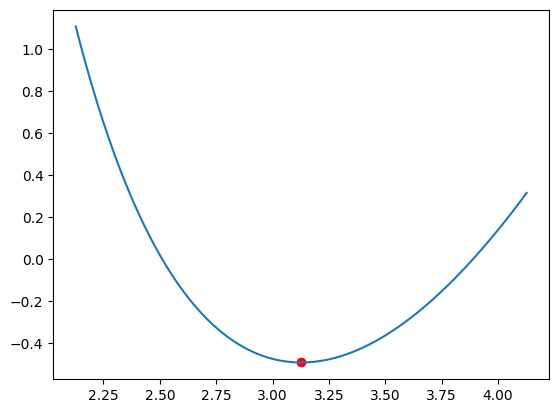

In [5]:
ff = lambdify(a,f_of_a, 'numpy')
aas = np.linspace(sol - 1, sol + 1, 100)
plt.plot(aas, ff(aas))
plt.scatter([sol] ,[ff(sol)], c= 'r');

# Backtracking line search
Is an approximate line search algorithm

We test different values of $\beta$ until we get a sufficient decrease in function value:
$$f(\vec{x}_{i+1} ) \leq f(\vec{x}_{i} ) + \beta \alpha \nabla_{\vec{d}_{i}} f(\vec{x}_{i})$$
Where $\nabla_{\vec{d}_{i}} f(\vec{x}_{i})$ is gradient in direction of $\vec{d}_{i}$.

Example:

$$f(x_1, x_2) = x_1^2 + x_1 x_2 + x_2^2$$ 
$$\vec{x} = \{1,2\}$$
$$\vec{d} = \{-1,-1\}$$
$$\nabla f (\vec{r}) = \{2 x_1 + x_2, 2 x_2 + x_1\}$$

Second Wolfe condition:


Given we are exploring local minimum, if we start search 'downhill' ($\vec{x}_i$) with negative slope, and reach hypothetical minimum with zero slope ($\vec{x}_{i+1}$), derivative at start is smaller than at finish. 

Any solutions in-between will still show this behavior. We can set a threshold value $\sigma$ for how relatively much slope will change.

$$ \frac{\nabla_{\vec{d}} f(\vec{x}_{i+1})}{\underbrace{\boxed{\nabla_{\vec{d}} f(\vec{x}_i)}}_{\leq 0}} \leq \sigma$$

this ratio takes values between 0 (at minimum) to 1 (at $\alpha = 0$). 

We want to make steps that are in values in-between:
$$\nabla_{\vec{d}} f(\vec{x}_{i+1}) \geq \sigma\nabla_{\vec{d}} f(\vec{x}_i)$$
*   if we set $\sigma = 0$, then we are satisfied with any steps sizes between start and hypothetical minimum.
*   the closer to $\sigma = 1$ the less change of slope we accept =  we stay closer to start.

This condition can reject a step size
https://www.youtube.com/watch?v=5upFcYJqSwo

In [6]:
f = pow(x,2) +x*y + pow(y,2) 
d,x0 = np.array([-1,-1]), np.array([1,2])
alpha = 10
rho = 0.5
beta = 1e-4
grad_f = Matrix([f]).jacobian((x,y))

sub_d = lambda vec: {x:vec[0], y:vec[1]}
grad_f_pt = grad_f.subs(sub_d(x0))
gd = grad_f_pt.dot(d)
sol = float('inf')
f_x = f.subs(sub_d(x0))
i = 0
while True:
    xad = x0 + alpha*d
    f_xad = f.subs(sub_d(xad))
    print(f'{i = };\t {alpha = };\t {f_xad = :0.1f};\t {f_x + beta*alpha*gd = :0.3f};\t {xad = }')
    if f_xad <=  f_x + beta*alpha*gd:
        sol = xad
        break

    alpha *= rho
    i += 1

# second Wolfe condition check
sigma = 0.9
print_tex(f'${grad_f.subs(sub_d(sol)).dot(d):0.3f} \geq {sigma*grad_f.subs(sub_d(x0)).dot(d):0.3f}$')

i = 0;	 alpha = 10;	 f_xad = 217.0;	 f_x + beta*alpha*gd = 6.991;	 xad = array([-9, -8])
i = 1;	 alpha = 5.0;	 f_xad = 37.0;	 f_x + beta*alpha*gd = 6.996;	 xad = array([-4., -3.])
i = 2;	 alpha = 2.5;	 f_xad = 3.2;	 f_x + beta*alpha*gd = 6.998;	 xad = array([-1.5, -0.5])


<IPython.core.display.Math object>